In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

import pickle

In [32]:
WORK_DIR = 'C:/Universitetas/Kursinis/Dataset'
# os.listdir(WORK_DIR)

In [33]:
print('Iš viso nuotraukų: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Iš viso nuotraukų: 21397


In [34]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [35]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
# train_labels.head()

In [36]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 300

In [37]:
train_labels.label = train_labels.label.astype('str')

train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [38]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [39]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [40]:
model_save = ModelCheckpoint('./EfficientNetB0_08.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, reduce_lr]
)

Epoch 1/10
1069/1069 [==============================] - 458s 421ms/step - loss: 0.6522 - acc: 0.7649 - val_loss: 0.5810 - val_acc: 0.7967

Epoch 00001: val_loss improved from inf to 0.58097, saving model to ./Input30010\model08.h5
Epoch 2/10
1069/1069 [==============================] - 391s 365ms/step - loss: 0.5250 - acc: 0.8173 - val_loss: 0.5309 - val_acc: 0.8252

Epoch 00002: val_loss improved from 0.58097 to 0.53093, saving model to ./Input30010\model08.h5
Epoch 3/10
1069/1069 [==============================] - 390s 364ms/step - loss: 0.4842 - acc: 0.8333 - val_loss: 0.5579 - val_acc: 0.8060

Epoch 00003: val_loss did not improve from 0.53093
Epoch 4/10
1069/1069 [==============================] - 399s 373ms/step - loss: 0.4688 - acc: 0.8374 - val_loss: 0.4493 - val_acc: 0.8516

Epoch 00004: val_loss improved from 0.53093 to 0.44934, saving model to ./Input30010\model08.h5
Epoch 5/10
1069/1069 [==============================] - 395s 369ms/step - loss: 0.4541 - acc: 0.8424 - val_lo

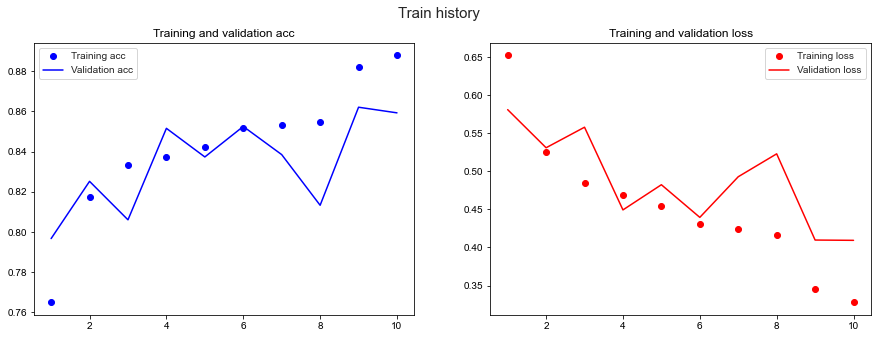

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [34]:
model.save('./EfficientNetB0_08.h5')

In [42]:
# with open('./EfficientNetB0_08_history', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

In [ ]:
model = models.load_model('./EfficientNetB0_08.h5')

In [19]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

,image_id,label
0,2216849948.jpg,4


In [20]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

,image_id,label
0,2216849948.jpg,4
